# **Import**

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

# **Data Load**

In [ ]:
cd /content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data

/content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data


In [ ]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i + 1}' for i in range(21)]
col_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('./train_FD001.csv')

In [ ]:
max_cycle = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']

train_df = train_df.merge(max_cycle, on='unit_number', how='left')

train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

# **Model**

In [ ]:
features = [
    'unit_number', 'time_cycles',
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12',
    's_13', 's_14', 's_15', 's_17', 's_20', 's_21', 'RUL'
]
train_df = train_df[features]
train_df.head()

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [ ]:
agg_features = []
using_sensor = [
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12',
    's_13', 's_14', 's_15', 's_17', 's_20', 's_21',
]

for unit in train_df['unit_number'].unique():
    unit_data = train_df[train_df['unit_number'] == unit]
    for t in range(2, len(unit_data)+1):  # 최소 2개 시점부터
        sub_data = unit_data.iloc[:t]  # 1~t
        features = {'unit_number': unit, 'time_cycles': sub_data['time_cycles'].iloc[-1]}

        for sensor in using_sensor:
            features[f'{sensor}_mean'] = sub_data[sensor].mean()
            features[f'{sensor}_std'] = sub_data[sensor].std()
            features[f'{sensor}_min'] = sub_data[sensor].min()
            features[f'{sensor}_max'] = sub_data[sensor].max()
            features[f'{sensor}_last'] = sub_data[sensor].iloc[-1]
            features[f'{sensor}_median'] = sub_data[sensor].median()
            # trend는 최소 2개 이상 시점에서만 계산 가능
            features[f'{sensor}_trend'] = np.polyfit(sub_data['time_cycles'], sub_data[sensor], 1)[0]

        # RUL은 해당 시점에서 남은 수명
        features['RUL'] = sub_data['RUL'].iloc[-1]

        agg_features.append(features)

agg_df = pd.DataFrame(agg_features)

In [ ]:
agg_df.head()

,unit_number,time_cycles,s_2_mean,s_2_std,s_2_min,s_2_max,s_2_last,s_2_median,s_2_trend,s_3_mean,...,s_20_median,s_20_trend,s_21_mean,s_21_std,s_21_min,s_21_max,s_21_last,s_21_median,s_21_trend,RUL
0,1,2,641.985000,0.233345,641.82,642.15,642.15,641.985,0.330000,1590.760000,...,39.030,-0.060,23.421300,0.003253,23.4190,23.4236,23.4236,23.42130,0.00460,190
1,1,3,642.106667,0.267644,641.82,642.35,642.35,642.150,0.265000,1589.836667,...,39.000,-0.055,23.395600,0.044573,23.3442,23.4236,23.3442,23.41900,-0.03740,189
2,1,4,642.167500,0.250117,641.82,642.35,642.35,642.250,0.179000,1588.075000,...,38.975,-0.059,23.390175,0.037977,23.3442,23.4236,23.3739,23.39645,-0.02147,188
3,1,5,642.208000,0.234776,641.82,642.37,642.37,642.350,0.130000,1587.030000,...,38.950,-0.044,23.393020,0.033498,23.3442,23.4236,23.4044,23.40440,-0.00789,187
4,1,6,642.190000,0.214569,641.82,642.37,642.10,642.250,0.058857,1586.603333,...,38.965,-0.022,23.388667,0.031803,23.3442,23.4236,23.3669,23.38915,-0.00824,186


In [ ]:
x = agg_df.drop(['unit_number','RUL'], axis=1)
y = agg_df['RUL']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## **XGBoost**

In [ ]:
xgb_model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05)
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_val)

In [ ]:
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
xgb_mae = mean_absolute_error(y_val, xgb_pred)

print(f"RMSE: {xgb_rmse:.3f}, MAE: {xgb_mae:.3f}")

RMSE: 4.471, MAE: 2.685


## **LightGBM**

In [ ]:
lgb_model = LGBMRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, verbose=-1)
lgb_model.fit(x_train, y_train)
lgb_pred = lgb_model.predict(x_val)

In [ ]:
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
lgb_mae = mean_absolute_error(y_val, lgb_pred)

print(f"RMSE: {lgb_rmse:.3f}, MAE: {lgb_mae:.3f}")

RMSE: 4.843, MAE: 3.044


# **Predict RUL**

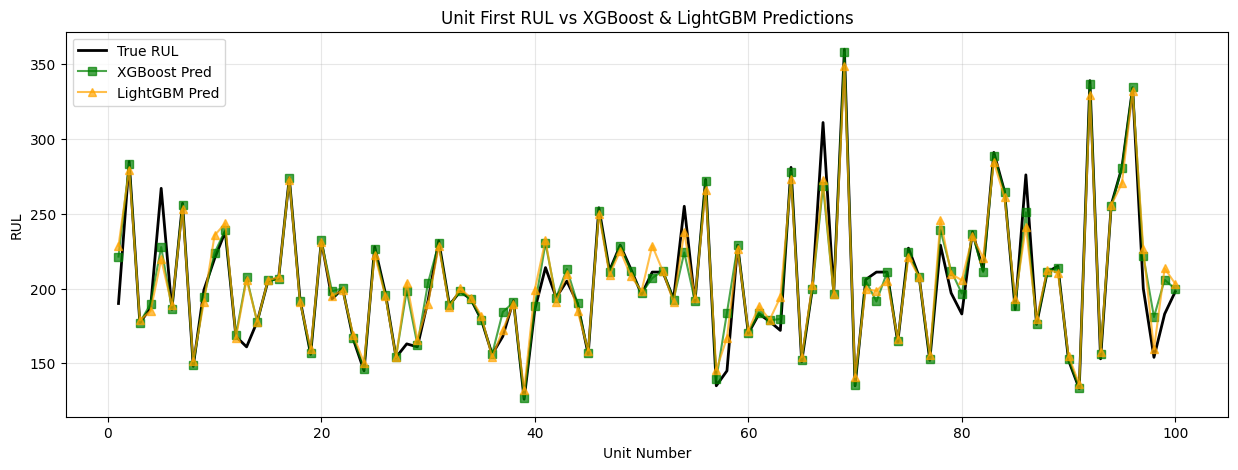

In [ ]:
unit_ids = agg_df['unit_number'].unique()
rul_df = agg_df.groupby('unit_number')['RUL'].max().reset_index()

true_first_rul = []
xgb_first_pred = []
lgb_first_pred = []

for unit in unit_ids:
    unit_rows = agg_df[agg_df['unit_number'] == unit]
    first_idx = unit_rows.index[0]

    true_first_rul.append(rul_df.loc[unit-1, 'RUL'])  # test set일 경우 RUL_FD001.csv 사용
    xgb_first_pred.append(xgb_model.predict(unit_rows.drop(['unit_number','RUL'], axis=1).iloc[[0]])[0])
    lgb_first_pred.append(lgb_model.predict(unit_rows.drop(['unit_number','RUL'], axis=1).iloc[[0]])[0])

df_compare = pd.DataFrame({
    'unit_number': unit_ids,
    'True_RUL': true_first_rul,
    'XGB_RUL': xgb_first_pred,
    'LGBM_RUL': lgb_first_pred
})

plt.figure(figsize=(15,5))
plt.plot(df_compare['unit_number'], df_compare['True_RUL'], label='True RUL', color='black', linewidth=2)
plt.plot(df_compare['unit_number'], df_compare['XGB_RUL'], label='XGBoost Pred', color='green', marker='s', alpha=0.7)
plt.plot(df_compare['unit_number'], df_compare['LGBM_RUL'], label='LightGBM Pred', color='orange', marker='^', alpha=0.7)

plt.xlabel('Unit Number')
plt.ylabel('RUL')
plt.title('Unit First RUL vs XGBoost & LightGBM Predictions')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# **Test**

In [ ]:
test_df = pd.read_csv('./test_FD001.csv')
rul_df = pd.read_csv('./RUL_FD001.csv')

In [ ]:
features = [
    'unit_number', 'time_cycles',
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12',
    's_13', 's_14', 's_15', 's_17', 's_20', 's_21'
]
test_df = test_df[features]
test_df.head()

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130


In [ ]:
agg_features = []
using_sensor = [
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12',
    's_13', 's_14', 's_15', 's_17', 's_20', 's_21',
]

for unit in test_df['unit_number'].unique():
    unit_data = test_df[test_df['unit_number'] == unit]
    features = {'unit_number': unit, 'time_cycles': unit_data['time_cycles'].max()}

    for sensor in using_sensor:
        features[f'{sensor}_mean'] = unit_data[sensor].mean()
        features[f'{sensor}_std'] = unit_data[sensor].std()
        features[f'{sensor}_min'] = unit_data[sensor].min()
        features[f'{sensor}_max'] = unit_data[sensor].max()
        features[f'{sensor}_last'] = unit_data[sensor].iloc[-1]
        features[f'{sensor}_median'] = unit_data[sensor].median()
        features[f'{sensor}_trend'] = np.polyfit(unit_data['time_cycles'], unit_data[sensor], 1)[0]  # 선형 추세

    agg_features.append(features)

agg_df = pd.DataFrame(agg_features)

In [ ]:
agg_df.head()

,unit_number,time_cycles,s_2_mean,s_2_std,s_2_min,s_2_max,s_2_last,s_2_median,s_2_trend,s_3_mean,...,s_20_last,s_20_median,s_20_trend,s_21_mean,s_21_std,s_21_min,s_21_max,s_21_last,s_21_median,s_21_trend
0,1,31,642.319032,0.299414,641.71,643.02,642.58,642.320,0.001476,1585.647742,...,38.81,39.00,-0.002367,23.379097,0.034857,23.3186,23.4572,23.3552,23.37700,-0.000686
1,2,49,642.605510,0.262012,641.91,643.33,642.55,642.580,0.005880,1589.181429,...,38.81,38.84,0.000214,23.313918,0.063168,23.2196,23.5222,23.2618,23.30650,-0.001602
2,3,126,642.693810,0.309588,642.03,643.44,642.88,642.660,0.002723,1590.588095,...,38.93,38.83,-0.000590,23.280522,0.063094,23.1391,23.4232,23.2740,23.28705,-0.000679
3,4,106,642.577170,0.340601,641.77,643.48,642.78,642.560,0.004014,1589.685094,...,38.58,38.85,-0.000355,23.297936,0.059031,23.1465,23.4121,23.2581,23.29465,-0.000455
4,5,98,642.639694,0.322980,641.82,643.35,642.27,642.665,-0.000131,1589.443673,...,38.75,38.84,-0.001089,23.295200,0.060642,23.1476,23.4622,23.4117,23.29635,-0.000824


In [ ]:
x_test = agg_df.drop(['unit_number'], axis=1)
y_test = rul_df['RUL']

In [ ]:
xgb_pred = xgb_model.predict(x_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)

print(f"RMSE: {xgb_rmse:.3f}, MAE: {xgb_mae:.3f}")

RMSE: 21.847, MAE: 13.757


In [ ]:
lgb_pred = lgb_model.predict(x_test)

lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_mae = mean_absolute_error(y_test, lgb_pred)

print(f"RMSE: {lgb_rmse:.3f}, MAE: {lgb_mae:.3f}")

RMSE: 20.470, MAE: 13.212


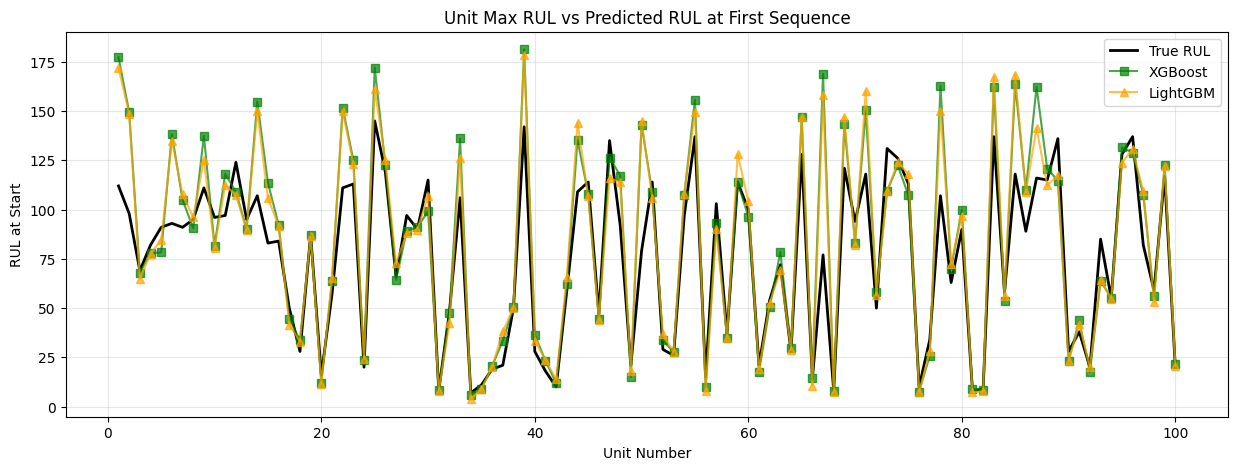

In [ ]:
unit_ids = agg_df['unit_number']
true_max_rul = rul_df['RUL']

xgb_pred_full = xgb_model.predict(x_test)
lgb_pred_full = lgb_model.predict(x_test)

df_rul_compare = pd.DataFrame({
    'unit_number': unit_ids,
    'True_RUL': true_max_rul,
    'XGB_RUL': xgb_pred_full,
    'LGBM_RUL': lgb_pred_full
})

plt.figure(figsize=(15,5))
plt.plot(df_rul_compare['unit_number'], df_rul_compare['True_RUL'], label='True RUL', color='black', linewidth=2)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['XGB_RUL'], label='XGBoost', color='green', marker='s', alpha=0.7)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['LGBM_RUL'], label='LightGBM', color='orange', marker='^', alpha=0.7)

plt.xlabel('Unit Number')
plt.ylabel('RUL at Start')
plt.title('Unit Max RUL vs Predicted RUL at First Sequence')
plt.legend()
plt.grid(alpha=0.3)
plt.show()